# Encoding for Neuroevolution


This notebook introduces the GENE encoding for neuroevolution and presents some results for direct and indirect encoding of the genomes.

In [1]:
import jax.random as jrd
import jax.profiler as profiler
from jax import jit, vmap
import matplotlib.pyplot as plt

from run import run

import copy
from functools import partial

plt.style.use("bmh")  # fivethirtyeight

Define the _config_ object, containing all the information about a single run.

In [2]:
config_gene = {
    "evo": {"strategy_name": "SNES", "n_generations": 100, "population_size": 30},
    "net": {"layer_dimensions": [4, 32, 2]},
    "encoding": {"d": 3, "distance": "pL2", "type": "gene"},
    "problem": {"environnment": "CartPole-v1", "maximize": True},
}

config_direct = copy.deepcopy(config_gene)
config_direct["encoding"]["type"] = "direct"

Define an utility plot function.

In [3]:
def plot(*args, info: str = ""):
    """Simple plotting utility function"""
    plt.figure(figsize=(12, 6))
    for m, s, label in args:
        plt.fill_between(range(len(m)), m + 0.5 * s, m - 0.5 * s, alpha=0.35)
        plt.plot(m, label=label)
    plt.xlabel("n° generations")
    plt.ylabel("fitness")
    plt.title(f"Mean fitness over generations\n{info}")
    plt.legend()
    plt.show()

Evaluate the two defined config at the beginning using the mean and standart-deviation of 10 runs.

In [4]:
def evaluate_bench(config: dict, rng: jrd.KeyArray = jrd.PRNGKey(0), n: int = 10):
    rng_run = jrd.split(rng, n)
    vmap_run = vmap(partial(run, config=config))
    _, logs = vmap_run(rng=rng_run)
    return {
        "fit_best": logs["log_gen_1"].mean(axis=0),
        "fit_best_std": logs["log_gen_1"].std(axis=0),
        "mean_fit": logs["log_gen_mean"].mean(axis=0),
        "mean_fit_std": logs["log_gen_std"].mean(axis=0),
        "logs": logs
    }

In [5]:
rng = jrd.PRNGKey(0)

gene_results = evaluate_bench(config_gene, rng)
direct_results = evaluate_bench(config_direct, rng)

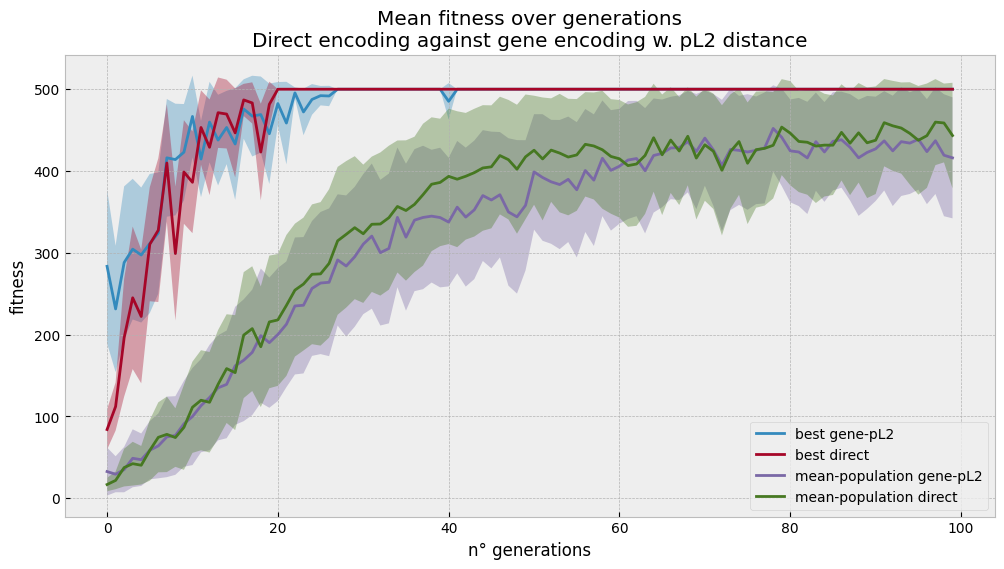

: 

In [6]:
plot(
    (gene_results["fit_best"], gene_results["fit_best_std"], "best gene-pL2"),
    (direct_results["fit_best"], direct_results["fit_best_std"], "best direct"),
    (
        gene_results["mean_fit"],
        gene_results["mean_fit_std"],
        "mean-population gene-pL2",
    ),
    (
        direct_results["mean_fit"],
        direct_results["mean_fit_std"],
        "mean-population direct",
    ),
    info="Direct encoding against gene encoding w. pL2 distance",
)

In [ ]:
plt.plot()

Let's extract the genome of our best individual, create our network and let it play.

In [17]:
%pip install gym==0.19.0 pyglet==1.5.27 PyOpenGL


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3.9 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [18]:
!pip freeze | grep gym

gym==0.19.0
gym-notices==0.0.8
gymnasium==0.28.1
gymnax==0.0.6


In [21]:
%%capture
from gene.visualization import run_env
# Take the top-1 param of our first run


animation_file = run_env(
    genome=gene_results['logs']['top_params'][0][0],
    config=config_gene
)

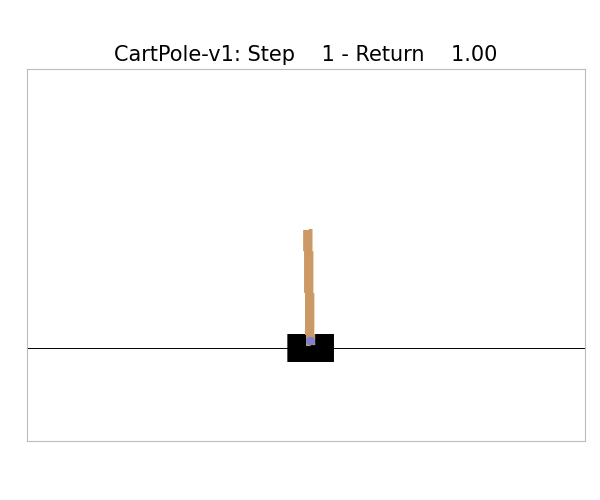

In [22]:
from IPython.display import Image
Image(filename=animation_file)

---

## Time and memory comparison of the direct and indirect encoding methods


Since everything is parallelized, direct encoding is not slower than indirect encoding. However, it is important to note that an exponential increase in memory usage should be expected using direct encoding.

### Execution time comparison 

In [10]:
%timeit evaluate_bench(config_gene)

4.15 s ± 69.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%timeit evaluate_bench(config_direct)

3.82 s ± 60 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
from gene.encoding import direct_enc_genome_size

direct_enc_genome_size(config_direct)

2338

### Memory consumption comparison

When comparing the memory consumption of the direct encoding and the indirect encoding, one can see a drastic difference int the total memory usage.

Using the GENE encoding instead of direct encoding leads to a reduction in memory usage of around 40% as depicted in the following graph.

In [9]:
# https://jax.readthedocs.io/en/latest/device_memory_profiling.html
!pprof --png --diff_base profiles/direct_trace/memory.prof profiles/gene_trace/memory.prof

Main binary filename not available.
Generating report in profile001.png


<p align="center">
  <img height="1000" src="profiles/gene_vs_direct.png">
</p>